In [62]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import roc_functions
from statsmodels.othermod.betareg import BetaModel
from scipy.interpolate import interp1d

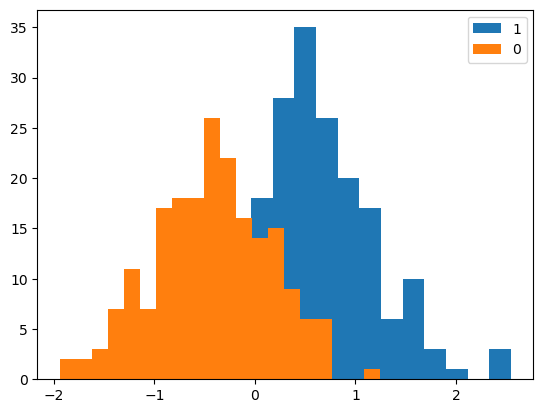

In [2]:
X, y = make_classification(n_features =1, 
                           n_informative = 1, 
                           n_redundant=0, 
                           n_clusters_per_class=1,
                           flip_y = 0,
                           class_sep=0.5, n_samples = 400)
X = X.flatten()
# for i, y_i in enumerate(y):
#     if y_i == 1:
#         fpr, tpr, _ = roc_curve(np.delete(y, i),np.delete(X,i))
#         plt.plot(fpr, tpr
plt.hist(X[y==1],bins=20,label = 1)
plt.hist(X[y==0],bins=20,label = 0)
plt.legend()
plt.show()

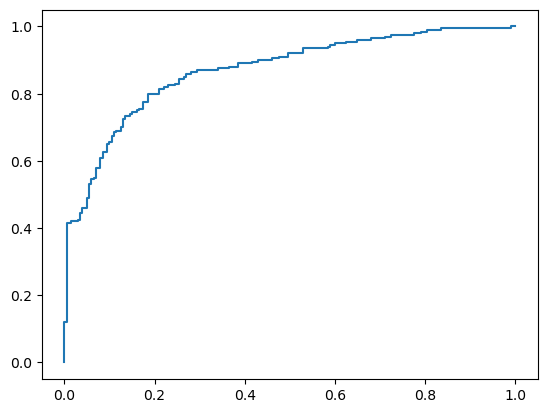

In [3]:
fpr, tpr, _ = roc_curve(y, X)
plt.plot(fpr, tpr)
plt.show()

In [4]:
auc(fpr, tpr)

0.8692500000000001

In [86]:
def auroc_bootstrap(y_predicted, y_test, iter= 10000):
    
    actives = y_predicted[np.where(y_test==1)[0]]
    inactives = y_predicted[np.where(y_test==0)[0]]
    
    aurocs = np.zeros(iter)
    
    for i in range(iter):
        # choose a bootstrap sample of inactives with replacement
        bootstrap_actives = np.random.choice(actives.flatten(), size=actives.shape[0])
        # choose a bootstrap sample of inactives with replacement
        bootstrap_inactives = np.random.choice(inactives.flatten(), size=inactives.shape[0])
        # calculate the mean AUROC for this case
        aurocs[i] = (bootstrap_actives > bootstrap_inactives[:,np.newaxis]).mean()
    return aurocs

def roc_bootstrap(y_predicted, y_test, iter= 10000):
    
    actives = y_predicted[np.where(y_test==1)[0]]
    inactives = y_predicted[np.where(y_test==0)[0]]
    y_test_bootstrap = np.concatenate((np.ones_like(actives), np.zeros_like(inactives)))
    fprs = []
    tprs = []
    
    for i in range(iter):
        # choose bootstrap samples and construct dataset
        bootstrap_actives = np.random.choice(actives.flatten(), size=actives.shape[0])
        bootstrap_inactives = np.random.choice(inactives.flatten(), size=inactives.shape[0])
        y_predicted_bootstrap = np.concatenate((bootstrap_actives, bootstrap_inactives))
        # calculate the ROC for this case        
        fpr, tpr, _ = roc_curve(y_test_bootstrap, y_predicted_bootstrap)
        fprs.append(fpr)
        tprs.append(tpr)
        
    return fprs, tprs

def auroc_cis(aurocs,alpha=0.33):   
    aurocs_sorted = np.sort(aurocs)
    auroc_median = aurocs_sorted[len(aurocs) // 2]

    auroc_lower_bound = aurocs_sorted[int(len(aurocs)*alpha)]
    auroc_upper_bound = aurocs_sorted[int(len(aurocs)*(1-alpha))]
    return (auroc_median, auroc_lower_bound, auroc_upper_bound)

def roc_cis(fprs, tprs, alpha=0.33, n_interpolating=100):
    N = len(fprs)
    fpr_ip = np.linspace(0,1,n_interpolating)
    tprs_ip = np.zeros((N, n_interpolating))
    for i in range(N):
        tprs_ip[i] = interp1d(fprs[i],tprs[i])(fpr_ip)
    tpr_lower = np.quantile(tprs_ip,0.1, axis=0)
    tpr_median = np.quantile(tprs_ip,0.5, axis=0)
    tpr_upper = np.quantile(tprs_ip,0.9, axis=0)
    return (fpr_ip, tpr_median, tpr_lower, tpr_upper)

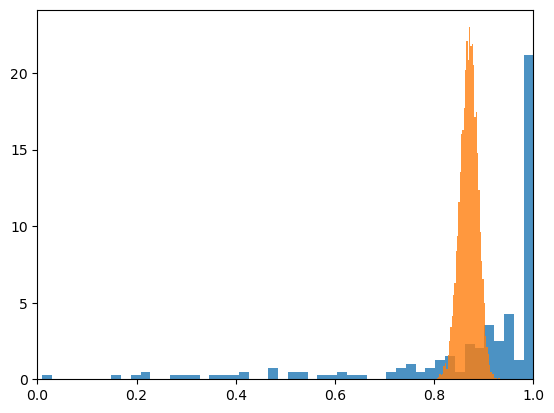

(0.945, 0.895, 0.995)
(0.8701, 0.86215, 0.877725)


In [87]:
aurocs = auroc_iterate(X, y)
plt.hist(aurocs, bins = 50, alpha=0.8, density=True)

aurocs_bootstrap = auroc_bootstrap(X, y,iter = 10000)
plt.hist(aurocs_bootstrap, bins = 50, alpha=0.8, density=True)


plt.xlim((0,1))
plt.show()
print(auroc_cis(aurocs, alpha = 0.33))
print(auroc_cis(aurocs_bootstrap, alpha=0.33))

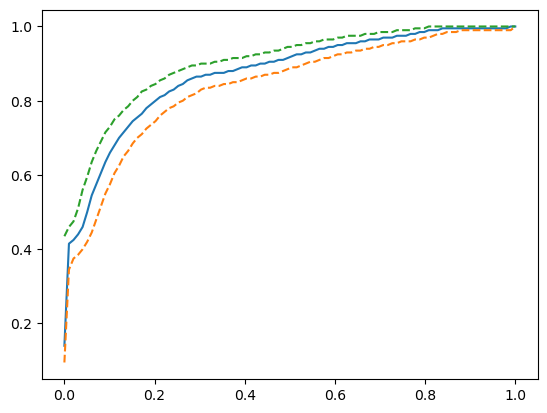

In [89]:
fprs, tprs = roc_bootstrap(X, y)
fpr, tpr_median, tpr_lower, tpr_upper = roc_cis(fprs, tprs)

plt.plot(fpr, tpr_median)
plt.plot(fpr, tpr_lower, linestyle='dashed')
plt.plot(fpr, tpr_upper, linestyle='dashed')
plt.show()